# Bangsgaard and Ottesen (2017) Model Code

# Table of Contents
1. [Imports](#imports)
2. [Parameters and Initial Conditions](#params)
3. [Put Raw Data into Arrays](#rawdata)
    1. [Smooth Data, if Desired](#smoothdata)
    2. [Re-run Code to Input Non-Smoothed Data into Array](#rerun)
    3. [Plot Data Sets](#plotdata)
4. [Model Function--Includes ODE Solver](#modelfunction)
5. [Cost Function Definition](#cost)
6. [Run the Optimization](#run)
7. [Save Output to File](#saveoutput)
8. [Compute Means and Std Devations of Parameters and Output as Table](#paramtable)
9. [Plots](#plots)
10. [No Optimization Run](#no-opt)
    1. [Plot the No-Optimization Simulation Against Raw Data](#no-optplot)
11. [No Optimization Run--Iterate Over Multiple CRH Initial Conditions](#multipleCRH)
12. [Dependencies](#dependencies)

## Imports <a name="imports"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
from scipy.interpolate import interp1d
import mpld3
from tabulate import tabulate
import matplotlib
import pandas as pd
from HPAmodeling import ODEsolver

## Parameters and Initial Conditions <a name="params"></a>

In [3]:
# initial conditions
# order is: CRH, ACTH, Cortisol

y0 = [2,8.725314,1.158798]

In [4]:
# authors' published parameters, from Table A1 & A2 for Control Patient F

a_0 = 3.9031e-4
a_1 = 6.839e12
a_2 = 1.7809e9
a_3 = 2.2803e4
a_4 = 1.7745e5
a_5 = 4.617e-4
mu = 5.83e2
w_1 = 0.0337
w_2 = 0.0205
w_3 = 0.0238
delta = 83.8
alpha = 300
k = 5
beta = 950
l = 6
eps = 0.01
N_c = 0.5217
T = 1440

authors_params = [a_0, a_1, a_2, a_3, a_4, a_5, mu, w_1, w_2, w_3, delta, alpha, k, beta, l, eps, N_c]

In [5]:
# parameters for hypercortisolemic patients
a_0 = 1.31e-1
a_1 = 1.29e13
a_2 = 1.78e9
mu = 583
a_3 = 2.28e4
a_4 = 1.77e5
a_5 = 3.03e-4
w_1 = 4.57e-2
w_2 = 1.46e-2
w_3 = 2.10e-2
delta = 2.01e1
alpha = 300
k = 5.
beta = 950.
l = 6.
eps = 0.01
N_c = 0.5217
T = 1440.

authors_params = [a_0, a_1, a_5, w_1, w_2, w_3, delta]

In [6]:
par = N_c
plus_minus = par*0.25
print(par - plus_minus, par + plus_minus)

0.39127500000000004 0.6521250000000001


In [7]:
# bounds for parameter optimization, based on Patient F parameters +- 25%
# order is: a_0, a_1, a_2, a_3, a_4, a_5, mu, w_1, w_2, w_3, delta, alpha, k, beta, l, eps, N_c
#bounds = [(0.0002927325, 0.0004878875), (5129250000000.0, 8548750000000.0), (1335675000.0, 2226125000.0), (17102.25, 28503.75), (133087.5, 221812.5), (0.000346275, 0.000577125), (437.25, 728.75), (0.025275, 0.042125), (0.015375, 0.025625), (0.01785, 0.02975), (62.85, 104.75), (225., 375.), (3.75, 6.25), (712.5, 1187.5), (4.5, 7.5), (0.0075, 0.0125), (0.391275, 0.652125)]


In [8]:
# expanded bounds, to see if that helps fitting at all
bounds = ([0., 0.1], [6.5e12, 7e12], [0., 0.05], [0., 0.6], [0., 0.4], [0., 0.35], [10., 5000.])

In [9]:
# time interval and step definition for integration
t_start = -0.01
t_end = 140.01
t_step = 0.01

## Put Raw Data Into Arrays <a name="rawdata"></a>

In [10]:
# generate arrays for the cortisol and ACTH data from control patient F in the Bangsgaard & Ottesen paper
patientFcortisol = np.genfromtxt("Bangsgaard-Ottesen-2017-patient-f-cortisol-data.txt")
patientFacth = np.genfromtxt("Bangsgaard-Ottesen-2017-patient-f-ACTH-data.txt")

In [11]:
yehudaControlCortisol = np.genfromtxt("yehuda-control-cortisol.txt")
yehudaPTSDCortisol = np.genfromtxt("yehuda-PTSD-cortisol.txt")
yehudaDepressedCortisol = np.genfromtxt("yehuda-depressed-cortisol.txt")

In [12]:
# extract the data from text files into 145x2 arrays
carrollControlCortisol = np.genfromtxt("controlGroupCortisolCarroll.txt", dtype = float)
carrollHCDepressedCortisol = np.genfromtxt("HCDepressedCortisolCarroll.txt", dtype = float)
carrollLCDepressedCortisol = np.genfromtxt("LCDepressedCortisolCarroll.txt", dtype = float)

carrollControlACTH = np.genfromtxt("controlGroupACTHCarroll.txt", dtype = float)
carrollHCDepressedACTH = np.genfromtxt("HCDepressedACTHCarroll.txt", dtype = float)
carrollLCDepressedACTH = np.genfromtxt("LCDepressedACTHCarroll.txt", dtype = float)

In [13]:
# rearrange Carroll data, so that we can start optimizing at midnight and go until 10AM 34 hours later
carrollControlCortisol_rearr = np.vstack((carrollControlCortisol[60:,:], carrollControlCortisol[0:60,:]))
carrollHCDepressedCortisol_rearr = np.vstack((carrollHCDepressedCortisol[60:,:], carrollHCDepressedCortisol[0:60,:]))
carrollLCDepressedCortisol_rearr = np.vstack((carrollLCDepressedCortisol[60:,:], carrollLCDepressedCortisol[0:60,:]))

carrollControlACTH_rearr = np.vstack((carrollControlACTH[60:,:], carrollControlACTH[0:60,:]))
carrollHCDepressedACTH_rearr = np.vstack((carrollHCDepressedACTH[60:,:], carrollHCDepressedACTH[0:60,:]))
carrollLCDepressedACTH_rearr = np.vstack((carrollLCDepressedACTH[60:,:], carrollLCDepressedACTH[0:60,:]))

In [14]:
golierPTSDCortisol = np.genfromtxt("golier-PTSD-cortisol.txt", dtype = float)
golierNonPTSDTraumaExposedCortisol = np.genfromtxt("golier-non-PTSD-trauma-exposed-cortisol.txt", dtype = float)
golierNonPTSDNonExposedCortisol = np.genfromtxt("golier-non-exposed-control-cortisol.txt", dtype = float)

golierPTSDACTH = np.genfromtxt("golier-PTSD-ACTH.txt", dtype = float)
golierNonPTSDTraumaExposedACTH = np.genfromtxt("golier-non-PTSD-trauma-exposed-ACTH.txt", dtype = float)
golierNonPTSDNonExposedACTH = np.genfromtxt("golier-non-exposed-control-ACTH.txt", dtype = float)

In [15]:
golierPTSDCortisol_rearr = np.vstack((golierPTSDCortisol[7:,:], golierPTSDCortisol[0:7,:]))
golierNonPTSDTraumaExposedCortisol_rearr = np.vstack((golierNonPTSDTraumaExposedCortisol[7:,:], golierNonPTSDTraumaExposedCortisol[0:7,:]))
golierNonPTSDNonExposedCortisol_rearr = np.vstack((golierNonPTSDNonExposedCortisol[7:,:], golierNonPTSDNonExposedCortisol[0:7,:]))

golierPTSDACTH_rearr = np.vstack((golierPTSDACTH[3:,:], golierPTSDACTH[0:3,:]))
golierNonPTSDTraumaExposedACTH_rearr = np.vstack((golierNonPTSDTraumaExposedACTH[3:,:], golierNonPTSDTraumaExposedACTH[0:3,:]))
golierNonPTSDNonExposedACTH_rearr = np.vstack((golierNonPTSDNonExposedACTH[3:,:], golierNonPTSDNonExposedACTH[0:3,:]))

In [16]:
bremnerAbusedPTSDCortisol = np.genfromtxt("bremner-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedPTSDCortisol = np.genfromtxt("bremner-non-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedNonPTSDCortisol = np.genfromtxt("bremner-non-abused-non-PTSD-cortisol.txt", dtype = float)

In [17]:
bremnerAbusedPTSDCortisol_rearr = np.vstack((bremnerAbusedPTSDCortisol[68:,:],bremnerAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedPTSDCortisol_rearr = np.vstack((bremnerNonAbusedPTSDCortisol[68:,:],bremnerNonAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedNonPTSDCortisol_rearr = np.vstack((bremnerNonAbusedNonPTSDCortisol[68:,:],bremnerNonAbusedNonPTSDCortisol[0:68,:]))

In [18]:
# data from Dr Erik Nelson
nelsonACTH_data = np.genfromtxt("tsst_acth_nelson.txt")
nelsonCortisol_data = np.genfromtxt("tsst_cort_nelson.txt")

### Smooth Data, If Desired <a name="smoothdata"></a>

In [19]:
# this function computes the moving average over the neighboring 5 points
def smoothing(a, n=5) :
    idx = int((n-1)/2)
    ret = np.cumsum(a, dtype=float)
    ret[idx+1:-idx] = ret[n:] - ret[:-n]
    ret[idx] = ret[idx+2]
    return ret[idx:-idx] / n

In [20]:
# create arrays for the smoothed data
patientFcortisol_smooth = patientFcortisol
patientFacth_smooth = patientFacth

# run the smoothing function on the raw data
# REMEMBER: need to re-extract the data from the files into the non-smooth arrays to make them non-smooth.
#     I'm still not sure why it's smoothing the original data when I only save the values from the smoothing function
#     into the smooth arrays
patientFcortisol_smooth[2:-2,1] = smoothing(patientFcortisol[:,1])
patientFacth_smooth[2:-2,1] = smoothing(patientFacth[:,1])

In [21]:
yehudaControlCortisol_smooth = yehudaControlCortisol
yehudaPTSDCortisol_smooth = yehudaPTSDCortisol
yehudaDepressedCortisol_smooth = yehudaDepressedCortisol

yehudaControlCortisol_smooth[2:-2,1] = smoothing(yehudaControlCortisol[:,1])
yehudaPTSDCortisol_smooth[2:-2,1] = smoothing(yehudaPTSDCortisol[:,1])
yehudaDepressedCortisol_smooth[2:-2,1] = smoothing(yehudaDepressedCortisol[:,1])

In [22]:
# run smoothing if so desired
# REMEMBER: need to re-extract the data from the files into the non-smooth arrays to make them non-smooth.
#     I'm still not sure why it's smoothing the original data when I only save the values from the smoothing function
#     into the smooth arrays
carrollControlCortisol_smooth = carrollControlCortisol
carrollHCDepressedCortisol_smooth = carrollHCDepressedCortisol
carrollLCDepressedCortisol_smooth = carrollLCDepressedCortisol

carrollControlACTH_smooth = carrollControlACTH
carrollHCDepressedACTH_smooth = carrollHCDepressedACTH
carrollLCDepressedACTH_smooth = carrollLCDepressedACTH

carrollControlCortisol_rearr_smooth = carrollControlCortisol_rearr
carrollHCDepressedCortisol_rearr_smooth = carrollHCDepressedCortisol_rearr
carrollLCDepressedCortisol_rearr_smooth = carrollLCDepressedCortisol_rearr

carrollControlACTH_rearr_smooth = carrollControlACTH_rearr
carrollHCDepressedACTH_rearr_smooth = carrollHCDepressedACTH_rearr
carrollLCDepressedACTH_rearr_smooth = carrollLCDepressedACTH_rearr

carrollControlCortisol_smooth[2:-2,1] = smoothing(carrollControlCortisol[:,1])
carrollHCDepressedCortisol_smooth[2:-2,1] = smoothing(carrollHCDepressedCortisol[:,1])
carrollLCDepressedCortisol_smooth[2:-2,1] = smoothing(carrollLCDepressedCortisol[:,1])

carrollControlACTH_smooth[2:-2,1] = smoothing(carrollControlACTH[:,1])
carrollHCDepressedACTH_smooth[2:-2,1] = smoothing(carrollHCDepressedACTH[:,1])
carrollLCDepressedACTH_smooth[2:-2,1] = smoothing(carrollLCDepressedACTH[:,1])

carrollControlCortisol_rearr_smooth[2:-2,1] = smoothing(carrollControlCortisol_rearr[:,1])
carrollHCDepressedCortisol_rearr_smooth[2:-2,1] = smoothing(carrollHCDepressedCortisol_rearr[:,1])
carrollLCDepressedCortisol_rearr_smooth[2:-2,1] = smoothing(carrollLCDepressedCortisol_rearr[:,1])

carrollControlACTH_rearr_smooth[2:-2,1] = smoothing(carrollControlACTH_rearr[:,1])
carrollHCDepressedACTH_rearr_smooth[2:-2,1] = smoothing(carrollHCDepressedACTH_rearr[:,1])
carrollLCDepressedACTH_rearr_smooth[2:-2,1] = smoothing(carrollLCDepressedACTH_rearr[:,1])

In [23]:
golierPTSDCortisol_smooth = golierPTSDCortisol
golierNonPTSDTraumaExposedCortisol_smooth = golierNonPTSDTraumaExposedCortisol
golierNonPTSDNonExposedCortisol_smooth = golierNonPTSDNonExposedCortisol
golierPTSDACTH_smooth = golierPTSDACTH
golierNonPTSDTraumaExposedACTH_smooth = golierNonPTSDTraumaExposedACTH
golierNonPTSDNonExposedACTH_smooth = golierNonPTSDNonExposedACTH

golierPTSDCortisol_smooth[2:-2,1] = smoothing(golierPTSDCortisol[:,1])
golierNonPTSDTraumaExposedCortisol_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedCortisol[:,1])
golierNonPTSDNonExposedCortisol_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedCortisol[:,1])

golierPTSDACTH_smooth[2:-2,1] = smoothing(golierPTSDACTH[:,1])
golierNonPTSDTraumaExposedACTH_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedACTH[:,1])
golierNonPTSDNonExposedACTH_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedACTH[:,1])

In [24]:
golierPTSDCortisol_rearr_smooth = golierPTSDCortisol_rearr
golierNonPTSDTraumaExposedCortisol_rearr_smooth = golierNonPTSDTraumaExposedCortisol_rearr
golierNonPTSDNonExposedCortisol_rearr_smooth = golierNonPTSDNonExposedCortisol_rearr
golierPTSDACTH_rearr_smooth = golierPTSDACTH_rearr
golierNonPTSDTraumaExposedACTH_rearr_smooth = golierNonPTSDTraumaExposedACTH_rearr
golierNonPTSDNonExposedACTH_rearr_smooth = golierNonPTSDNonExposedACTH_rearr

golierPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(golierPTSDCortisol_rearr[:,1])
golierNonPTSDTraumaExposedCortisol_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedCortisol_rearr[:,1])
golierNonPTSDNonExposedCortisol_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedCortisol_rearr[:,1])

golierPTSDACTH_rearr_smooth[2:-2,1] = smoothing(golierPTSDACTH_rearr[:,1])
golierNonPTSDTraumaExposedACTH_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedACTH_rearr[:,1])
golierNonPTSDNonExposedACTH_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedACTH_rearr[:,1])

In [25]:
bremnerAbusedPTSDCortisol_rearr_smooth = bremnerAbusedPTSDCortisol_rearr
bremnerNonAbusedPTSDCortisol_rearr_smooth = bremnerNonAbusedPTSDCortisol_rearr
bremnerNonAbusedNonPTSDCortisol_rearr_smooth = bremnerNonAbusedNonPTSDCortisol_rearr

bremnerAbusedPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(bremnerAbusedPTSDCortisol_rearr[:,1])
bremnerNonAbusedPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(bremnerNonAbusedPTSDCortisol_rearr[:,1])
bremnerNonAbusedNonPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(bremnerNonAbusedNonPTSDCortisol_rearr[:,1])

In [26]:
bremnerAbusedPTSDCortisol_smooth = bremnerAbusedPTSDCortisol
bremnerNonAbusedPTSDCortisol_smooth = bremnerNonAbusedPTSDCortisol
bremnerNonAbusedNonPTSDCortisol_smooth = bremnerNonAbusedNonPTSDCortisol

bremnerAbusedPTSDCortisol_smooth[2:-2,1] = smoothing(bremnerAbusedPTSDCortisol[:,1])
bremnerNonAbusedPTSDCortisol_smooth[2:-2,1] = smoothing(bremnerNonAbusedPTSDCortisol[:,1])
bremnerNonAbusedNonPTSDCortisol_smooth[2:-2,1] = smoothing(bremnerNonAbusedNonPTSDCortisol[:,1])

### Re-run Code to Input Non-Smoothed Data into Array <a name="rerun"></a>

In [27]:
# generate arrays for the cortisol and ACTH data from control patient F in the Bangsgaard & Ottesen paper
patientFcortisol = np.genfromtxt("Bangsgaard-Ottesen-2017-patient-f-cortisol-data.txt")
patientFacth = np.genfromtxt("Bangsgaard-Ottesen-2017-patient-f-ACTH-data.txt")

In [28]:
yehudaControlCortisol = np.genfromtxt("yehuda-control-cortisol.txt")
yehudaPTSDCortisol = np.genfromtxt("yehuda-PTSD-cortisol.txt")
yehudaDepressedCortisol = np.genfromtxt("yehuda-depressed-cortisol.txt")

In [29]:
# extract the data from text files into 145x2 arrays
carrollControlCortisol = np.genfromtxt("controlGroupCortisolCarroll.txt", dtype = float)
carrollHCDepressedCortisol = np.genfromtxt("HCDepressedCortisolCarroll.txt", dtype = float)
carrollLCDepressedCortisol = np.genfromtxt("LCDepressedCortisolCarroll.txt", dtype = float)

carrollControlACTH = np.genfromtxt("controlGroupACTHCarroll.txt", dtype = float)
carrollHCDepressedACTH = np.genfromtxt("HCDepressedACTHCarroll.txt", dtype = float)
carrollLCDepressedACTH = np.genfromtxt("LCDepressedACTHCarroll.txt", dtype = float)

In [30]:
# rearrange Carroll data, so that we can start optimizing at midnight and go until 10AM 34 hours later
carrollControlCortisol_rearr = np.vstack((carrollControlCortisol[60:,:], carrollControlCortisol[0:60,:]))
carrollHCDepressedCortisol_rearr = np.vstack((carrollHCDepressedCortisol[60:,:], carrollHCDepressedCortisol[0:60,:]))
carrollLCDepressedCortisol_rearr = np.vstack((carrollLCDepressedCortisol[60:,:], carrollLCDepressedCortisol[0:60,:]))

carrollControlACTH_rearr = np.vstack((carrollControlACTH[60:,:], carrollControlACTH[0:60,:]))
carrollHCDepressedACTH_rearr = np.vstack((carrollHCDepressedACTH[60:,:], carrollHCDepressedACTH[0:60,:]))
carrollLCDepressedACTH_rearr = np.vstack((carrollLCDepressedACTH[60:,:], carrollLCDepressedACTH[0:60,:]))

In [31]:
golierPTSDCortisol = np.genfromtxt("golier-PTSD-cortisol.txt", dtype = float)
golierNonPTSDTraumaExposedCortisol = np.genfromtxt("golier-non-PTSD-trauma-exposed-cortisol.txt", dtype = float)
golierNonPTSDNonExposedCortisol = np.genfromtxt("golier-non-exposed-control-cortisol.txt", dtype = float)

golierPTSDACTH = np.genfromtxt("golier-PTSD-ACTH.txt", dtype = float)
golierNonPTSDTraumaExposedACTH = np.genfromtxt("golier-non-PTSD-trauma-exposed-ACTH.txt", dtype = float)
golierNonPTSDNonExposedACTH = np.genfromtxt("golier-non-exposed-control-ACTH.txt", dtype = float)

In [32]:
golierPTSDCortisol_rearr = np.vstack((golierPTSDCortisol[7:,:], golierPTSDCortisol[0:7,:]))
golierNonPTSDTraumaExposedCortisol_rearr = np.vstack((golierNonPTSDTraumaExposedCortisol[7:,:], golierNonPTSDTraumaExposedCortisol[0:7,:]))
golierNonPTSDNonExposedCortisol_rearr = np.vstack((golierNonPTSDNonExposedCortisol[7:,:], golierNonPTSDNonExposedCortisol[0:7,:]))

golierPTSDACTH_rearr = np.vstack((golierPTSDACTH[3:,:], golierPTSDACTH[0:3,:]))
golierNonPTSDTraumaExposedACTH_rearr = np.vstack((golierNonPTSDTraumaExposedACTH[3:,:], golierNonPTSDTraumaExposedACTH[0:3,:]))
golierNonPTSDNonExposedACTH_rearr = np.vstack((golierNonPTSDNonExposedACTH[3:,:], golierNonPTSDNonExposedACTH[0:3,:]))

In [33]:
bremnerAbusedPTSDCortisol = np.genfromtxt("bremner-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedPTSDCortisol = np.genfromtxt("bremner-non-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedNonPTSDCortisol = np.genfromtxt("bremner-non-abused-non-PTSD-cortisol.txt", dtype = float)

In [34]:
bremnerAbusedPTSDCortisol_rearr = np.vstack((bremnerAbusedPTSDCortisol[68:,:],bremnerAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedPTSDCortisol_rearr = np.vstack((bremnerNonAbusedPTSDCortisol[68:,:],bremnerNonAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedNonPTSDCortisol_rearr = np.vstack((bremnerNonAbusedNonPTSDCortisol[68:,:],bremnerNonAbusedNonPTSDCortisol[0:68,:]))

### Plot Data Sets <a name="plotdata"></a>

In [35]:
# convert the time scale to minutes so that it agrees with the ODEs

for i in range(len(patientFcortisol_smooth[:,0])):
    patientFcortisol_smooth[i,0] = patientFcortisol[i,0]*60
    patientFcortisol[i,0] *= 60
for i in range(len(patientFacth_smooth[:,0])):
    patientFacth_smooth[i,0] = patientFacth[i,0]*60
    patientFacth[i,0] *= 60

In [36]:
# change the time values of the rearranged sets so that 0 minutes is now 10AM
for i in range(len(carrollControlCortisol)):
    carrollControlCortisol_rearr[i,0] = carrollControlCortisol[i,0]
    carrollControlACTH_rearr[i,0] = carrollControlACTH[i,0]
    carrollHCDepressedCortisol_rearr[i,0] = carrollHCDepressedCortisol[i,0]
    carrollHCDepressedACTH_rearr[i,0] = carrollHCDepressedACTH[i,0]
    carrollLCDepressedCortisol_rearr[i,0] = carrollLCDepressedCortisol[i,0]
    carrollLCDepressedACTH_rearr[i,0] = carrollLCDepressedACTH[i,0]
    
    carrollControlCortisol_rearr_smooth[i,0] = carrollControlCortisol[i,0]
    carrollControlACTH_rearr_smooth[i,0] = carrollControlACTH[i,0]
    carrollHCDepressedCortisol_rearr_smooth[i,0] = carrollHCDepressedCortisol[i,0]
    carrollHCDepressedACTH_rearr_smooth[i,0] = carrollHCDepressedACTH[i,0]
    carrollLCDepressedCortisol_rearr_smooth[i,0] = carrollLCDepressedCortisol[i,0]
    carrollLCDepressedACTH_rearr_smooth[i,0] = carrollLCDepressedACTH[i,0]

In [37]:
for i in range(len(golierPTSDCortisol)):
    golierPTSDCortisol[i,0] = golierPTSDCortisol[i,0]*60
    golierNonPTSDTraumaExposedCortisol[i,0] = golierNonPTSDTraumaExposedCortisol[i,0]*60
    golierNonPTSDNonExposedCortisol[i,0] = golierNonPTSDNonExposedCortisol[i,0]*60
    
for i in range(len(golierPTSDACTH)):
    golierPTSDACTH[i,0] = golierPTSDACTH[i,0]*60
    golierNonPTSDTraumaExposedACTH[i,0] = golierNonPTSDTraumaExposedACTH[i,0]*60
    golierNonPTSDNonExposedACTH[i,0] = golierNonPTSDNonExposedACTH[i,0]*60

In [38]:
for i in range(len(golierPTSDCortisol[:,0])):
    golierPTSDCortisol_rearr[i,0] = golierPTSDCortisol[i,0]
    golierPTSDCortisol_rearr_smooth[i,0] = golierPTSDCortisol[i,0]
    golierNonPTSDTraumaExposedCortisol_rearr[i,0] = golierNonPTSDTraumaExposedCortisol[i,0]
    golierNonPTSDTraumaExposedCortisol_rearr_smooth[i,0] = golierNonPTSDTraumaExposedCortisol[i,0]
    golierNonPTSDNonExposedCortisol_rearr[i,0] = golierNonPTSDNonExposedCortisol[i,0]
    golierNonPTSDNonExposedCortisol_rearr_smooth[i,0] = golierNonPTSDNonExposedCortisol[i,0]
    
for i in range(len(golierPTSDACTH[:,0])):
    golierPTSDACTH_rearr[i,0] = golierPTSDACTH[i,0]
    golierPTSDACTH_rearr_smooth[i,0] = golierPTSDACTH[i,0]
    golierNonPTSDTraumaExposedACTH_rearr[i,0] = golierNonPTSDTraumaExposedACTH[i,0]
    golierNonPTSDTraumaExposedACTH_rearr_smooth[i,0] = golierNonPTSDTraumaExposedACTH[i,0]
    golierNonPTSDNonExposedACTH_rearr[i,0] = golierNonPTSDNonExposedACTH[i,0]
    golierNonPTSDNonExposedACTH_rearr_smooth[i,0] = golierNonPTSDNonExposedACTH[i,0]

In [39]:
for i in range(len(bremnerAbusedPTSDCortisol)):
    bremnerAbusedPTSDCortisol[i,0] = bremnerAbusedPTSDCortisol[i,0]*60
    bremnerNonAbusedPTSDCortisol[i,0] = bremnerNonAbusedPTSDCortisol[i,0]*60
    bremnerNonAbusedNonPTSDCortisol[i,0] = bremnerNonAbusedNonPTSDCortisol[i,0]*60

In [40]:
for i in range(len(bremnerAbusedPTSDCortisol[:,0])):
    bremnerAbusedPTSDCortisol_rearr[i,0] = bremnerAbusedPTSDCortisol[i,0]
    bremnerAbusedPTSDCortisol_rearr_smooth[i,0] = bremnerAbusedPTSDCortisol[i,0]
    bremnerNonAbusedPTSDCortisol_rearr[i,0] = bremnerNonAbusedPTSDCortisol[i,0]
    bremnerNonAbusedPTSDCortisol_rearr_smooth[i,0] = bremnerNonAbusedPTSDCortisol[i,0]
    bremnerNonAbusedNonPTSDCortisol_rearr[i,0] = bremnerNonAbusedNonPTSDCortisol[i,0]
    bremnerNonAbusedNonPTSDCortisol_rearr_smooth[i,0] = bremnerNonAbusedNonPTSDCortisol[i,0]

[Text(0, 0.5, 'Cortisol (micrograms/dL)'), Text(0.5, 0, 'Time (hours)')]

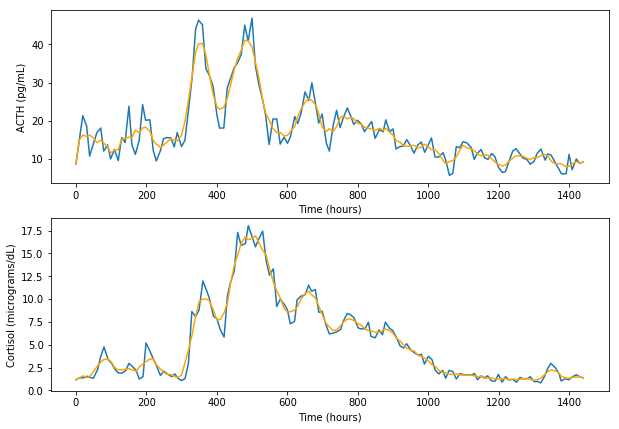

In [41]:
# plot the smoothed data to check it against the figures in the paper
#mpld3.enable_notebook()
%matplotlib inline
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(10,7))

ax1.plot(patientFacth[:,0], patientFacth[:,1])
ax1.plot(patientFacth_smooth[:,0], patientFacth_smooth[:,1], color = "orange")
ax1.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")

ax2.plot(patientFcortisol[:,0], patientFcortisol[:,1])
ax2.plot(patientFcortisol_smooth[:,0], patientFcortisol_smooth[:,1], color = "orange")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")

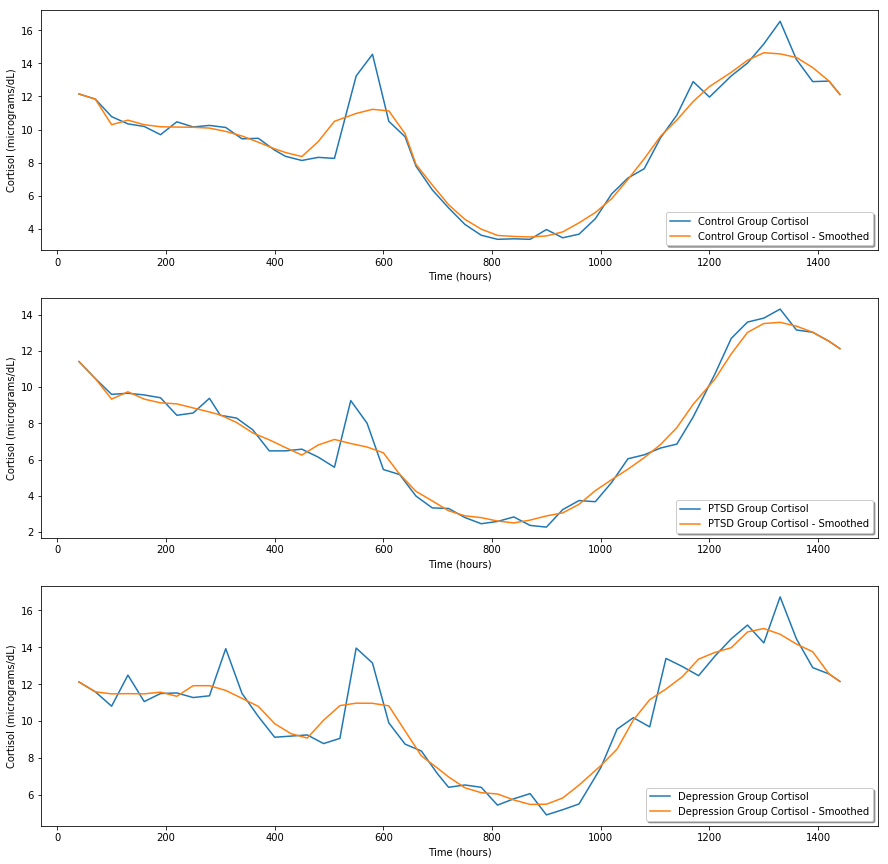

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(yehudaControlCortisol[:,0], yehudaControlCortisol[:,1], label = "Control Group Cortisol")
ax1.plot(yehudaControlCortisol_smooth[:,0], yehudaControlCortisol_smooth[:,1], label = "Control Group Cortisol - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(yehudaPTSDCortisol[:,0], yehudaPTSDCortisol[:,1], label = "PTSD Group Cortisol")
ax2.plot(yehudaPTSDCortisol_smooth[:,0], yehudaPTSDCortisol_smooth[:,1], label = "PTSD Group Cortisol - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(yehudaDepressedCortisol[:,0], yehudaDepressedCortisol[:,1], label = "Depression Group Cortisol")
ax3.plot(yehudaDepressedCortisol_smooth[:,0], yehudaDepressedCortisol_smooth[:,1], label = "Depression Group Cortisol - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)


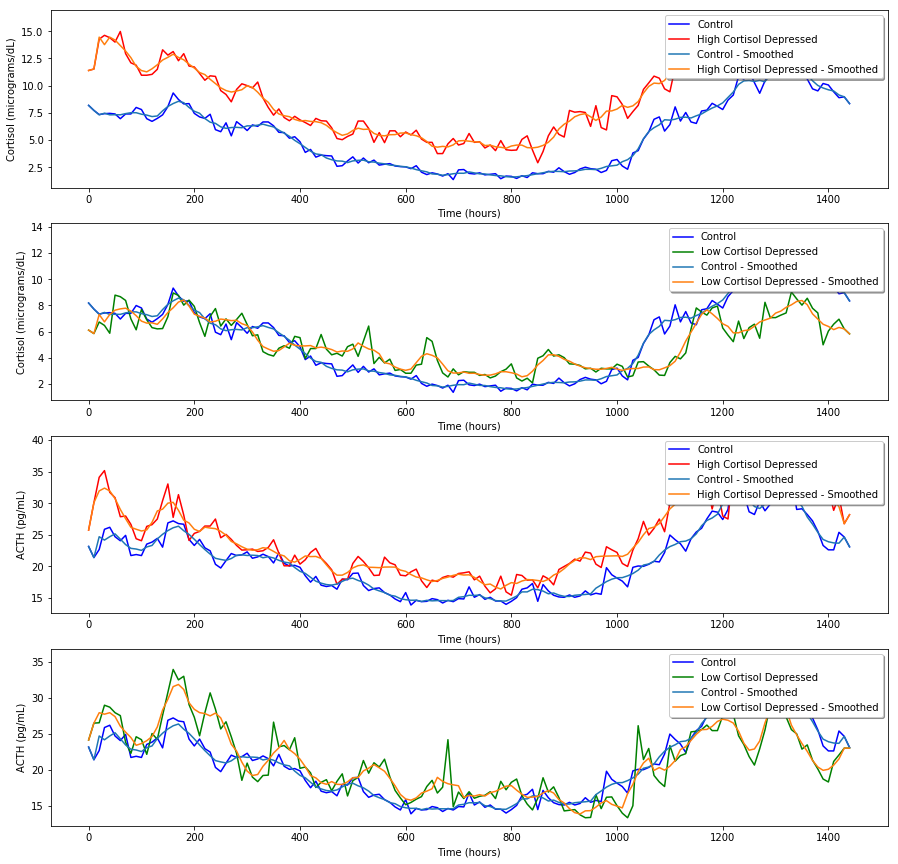

In [43]:
#mpld3.enable_notebook()
%matplotlib inline

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (15,15))

ax1.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax1.plot(carrollHCDepressedCortisol_rearr[:,0], carrollHCDepressedCortisol_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax1.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax1.plot(carrollHCDepressedCortisol_rearr_smooth[:,0], carrollHCDepressedCortisol_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="upper right", shadow = True, fancybox = True)

ax2.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax2.plot(carrollLCDepressedCortisol_rearr[:,0], carrollLCDepressedCortisol_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax2.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax2.plot(carrollLCDepressedCortisol_rearr_smooth[:,0], carrollLCDepressedCortisol_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="upper right", shadow = True, fancybox = True)

ax3.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax3.plot(carrollHCDepressedACTH_rearr[:,0], carrollHCDepressedACTH_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax3.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax3.plot(carrollHCDepressedACTH_rearr_smooth[:,0], carrollHCDepressedACTH_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax3.legend(loc="upper right", shadow = True, fancybox = True)

ax4.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax4.plot(carrollLCDepressedACTH_rearr[:,0], carrollLCDepressedACTH_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax4.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax4.plot(carrollLCDepressedACTH_rearr_smooth[:,0], carrollLCDepressedACTH_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax4.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="upper right", shadow = True, fancybox = True)

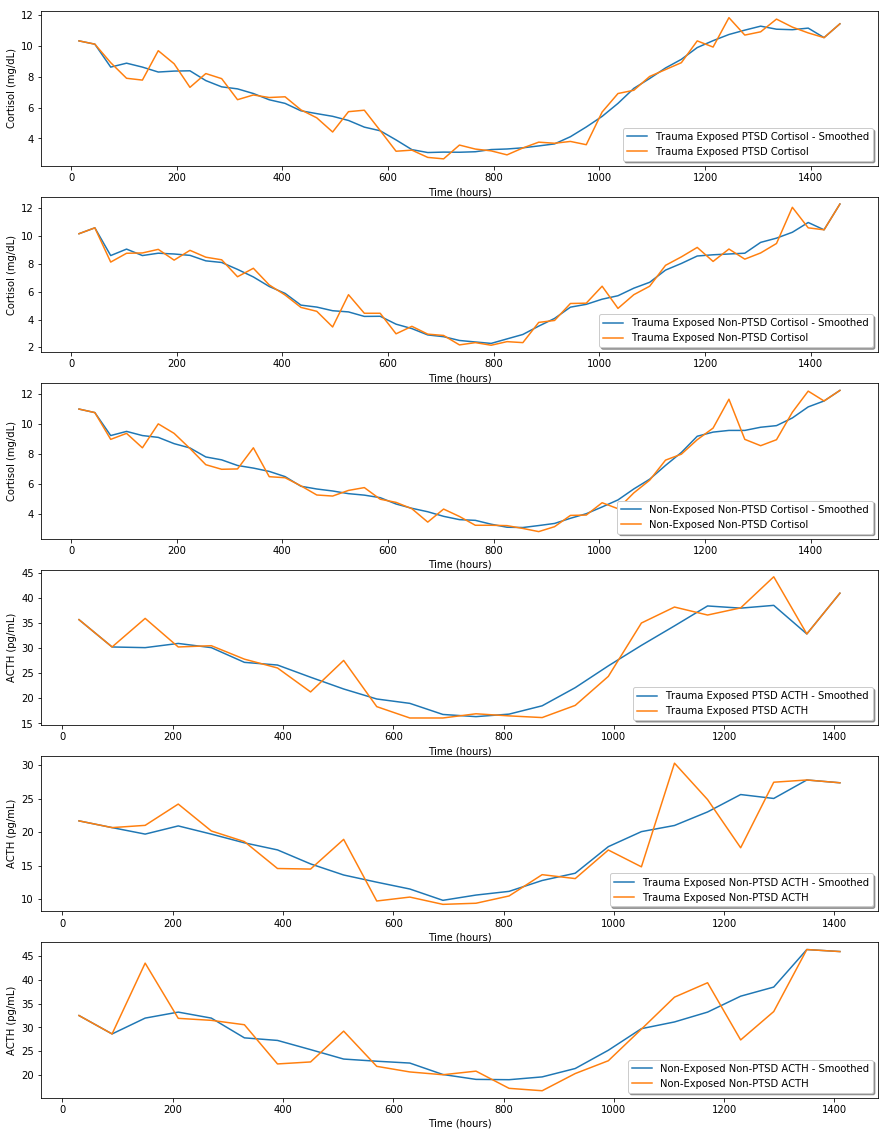

In [44]:
%matplotlib inline

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (15,20))

ax1.plot(golierPTSDCortisol_rearr_smooth[:,0], golierPTSDCortisol_rearr_smooth[:,1], label = "Trauma Exposed PTSD Cortisol - Smoothed")
ax1.plot(golierPTSDCortisol_rearr[:,0], golierPTSDCortisol_rearr[:,1], label = "Trauma Exposed PTSD Cortisol")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,0], golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD Cortisol - Smoothed")
ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr[:,0], golierNonPTSDTraumaExposedCortisol_rearr[:,1], label = "Trauma Exposed Non-PTSD Cortisol")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(golierNonPTSDNonExposedCortisol_rearr_smooth[:,0], golierNonPTSDNonExposedCortisol_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD Cortisol - Smoothed")
ax3.plot(golierNonPTSDNonExposedCortisol_rearr[:,0], golierNonPTSDNonExposedCortisol_rearr[:,1], label = "Non-Exposed Non-PTSD Cortisol")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)

ax4.plot(golierPTSDACTH_rearr_smooth[:,0], golierPTSDACTH_rearr_smooth[:,1], label = "Trauma Exposed PTSD ACTH - Smoothed")
ax4.plot(golierPTSDACTH_rearr[:,0], golierPTSDACTH_rearr[:,1], label = "Trauma Exposed PTSD ACTH")
ax4.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="lower right", shadow = True, fancybox = True)

ax5.plot(golierNonPTSDTraumaExposedACTH_rearr_smooth[:,0], golierNonPTSDTraumaExposedACTH_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD ACTH - Smoothed")
ax5.plot(golierNonPTSDTraumaExposedACTH_rearr[:,0], golierNonPTSDTraumaExposedACTH_rearr[:,1], label = "Trauma Exposed Non-PTSD ACTH")
ax5.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax5.legend(loc="lower right", shadow = True, fancybox = True)

ax6.plot(golierNonPTSDNonExposedACTH_rearr_smooth[:,0], golierNonPTSDNonExposedACTH_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD ACTH - Smoothed")
ax6.plot(golierNonPTSDNonExposedACTH_rearr[:,0], golierNonPTSDNonExposedACTH_rearr[:,1], label = "Non-Exposed Non-PTSD ACTH")
ax6.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax6.legend(loc="lower right", shadow = True, fancybox = True)


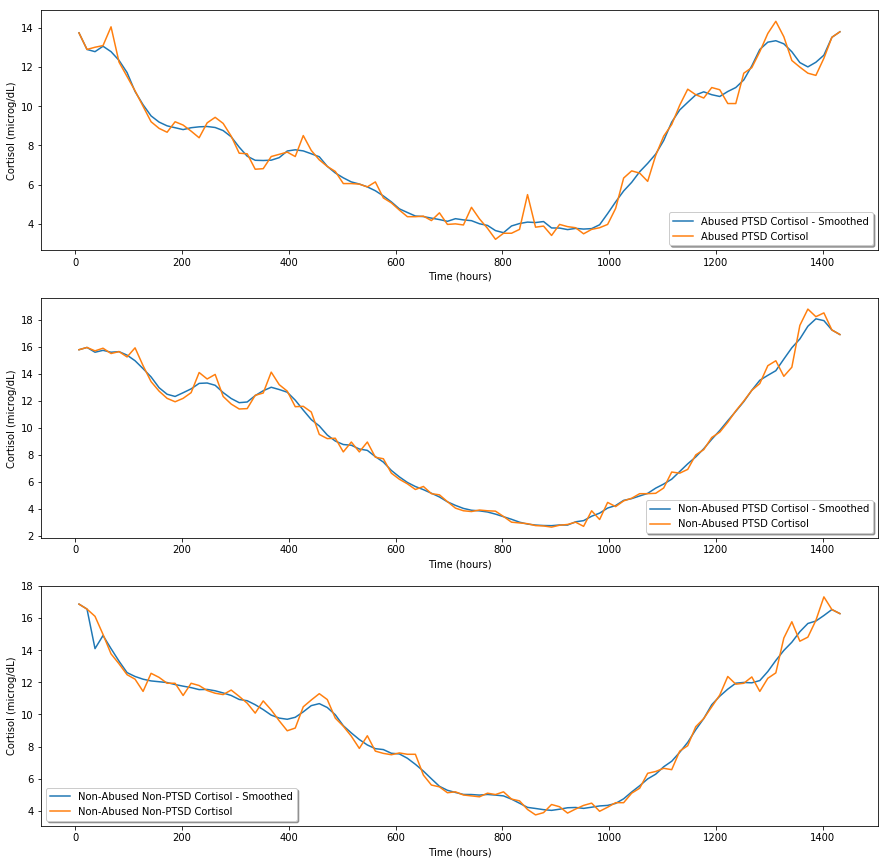

In [45]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(bremnerAbusedPTSDCortisol_rearr_smooth[:,0], bremnerAbusedPTSDCortisol_rearr_smooth[:,1], label = "Abused PTSD Cortisol - Smoothed")
ax1.plot(bremnerAbusedPTSDCortisol_rearr[:,0], bremnerAbusedPTSDCortisol_rearr[:,1], label = "Abused PTSD Cortisol")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(bremnerNonAbusedPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused PTSD Cortisol - Smoothed")
ax2.plot(bremnerNonAbusedPTSDCortisol_rearr[:,0], bremnerNonAbusedPTSDCortisol_rearr[:,1], label = "Non-Abused PTSD Cortisol")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused Non-PTSD Cortisol - Smoothed")
ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr[:,0], bremnerNonAbusedNonPTSDCortisol_rearr[:,1], label = "Non-Abused Non-PTSD Cortisol")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax3.legend(loc="lower left", shadow = True, fancybox = True)


In [46]:
# arrange and graph the Nelson data
nelsonACTH_mean = np.zeros(11)
nelsonCortisol_mean = np.zeros(11)
nelsonACTH = np.zeros((11,60))
nelsonCortisol = np.zeros((11,60))


for i in range(len(nelsonACTH_data[1,:])-1):
    nelsonACTH_mean[i] = np.mean(nelsonACTH_data[:,i+1])
    nelsonCortisol_mean[i] = np.mean(nelsonCortisol_data[:,i+1])

t_nelson = np.array([0, 15, 30, 40, 50, 65, 80, 95, 110, 125, 140])

for i in range(len(t_nelson)):
    nelsonACTH[i,0] = t_nelson[i]
    nelsonACTH[i,1] = nelsonACTH_mean[i]
    
    nelsonCortisol[i,0] = t_nelson[i]
    nelsonCortisol[i,1] = nelsonCortisol_mean[i]
    
for i in range(len(nelsonACTH_data)):
    for j in range(len(t_nelson)):
        nelsonACTH[j,i+2] = nelsonACTH_data[i,j+1]
        nelsonCortisol[j,i+2] = nelsonCortisol_data[i,j+1]

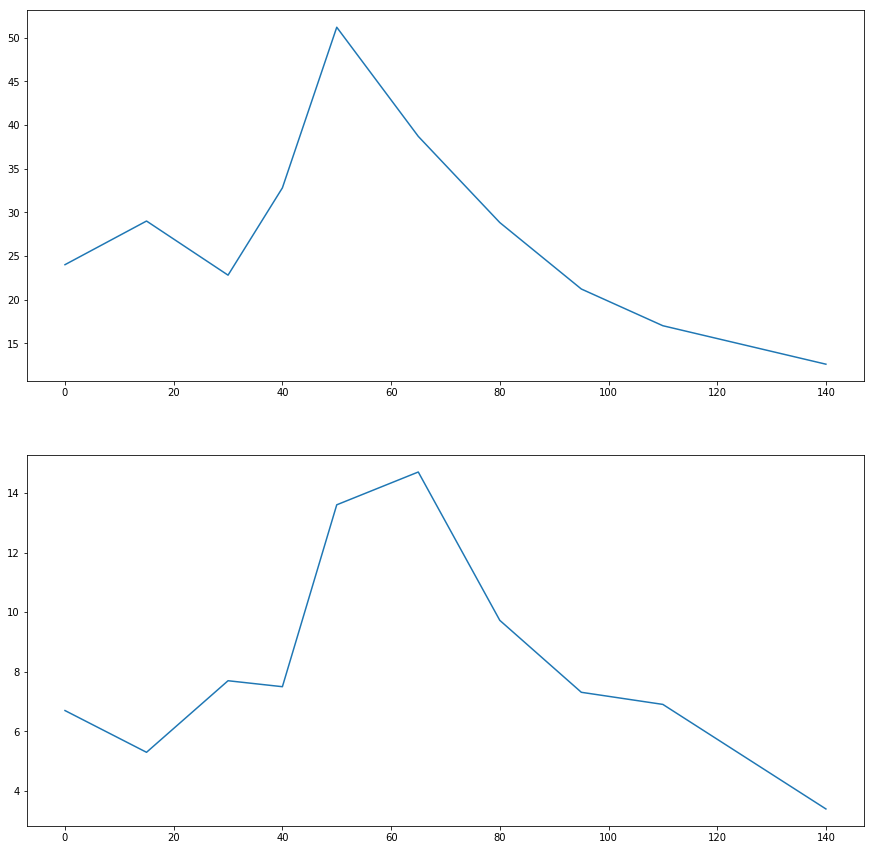

In [47]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 15))

ax1.plot(nelsonACTH[:,0], nelsonACTH[:,3])
ax2.plot(nelsonCortisol[:,0], nelsonCortisol[:,3])

## Model Function--Includes ODE Solver <a name="modelfunction"></a>

In [2]:
def model(params, ics):
    def ode_system(t, y):
        dy = np.zeros(3)

        [a_0, a_1, a_5, w_1, w_2, w_3, delta] = params
        
        dy[0] = a_0 + C(t, delta, alpha, beta, eps, k, l)*(a_1/(1 + a_2*y[2]**2))*(y[0]/(mu + y[0])) - w_1*y[0]
        dy[1] = (a_3*y[0])/(1 + a_4*y[2]) - w_2*y[1]
        dy[2] = a_5*(y[1]**2) - w_3*y[2]

        return dy
    
    def C(t, delta, alpha, beta, eps, k, l):
        t_m = (t - delta)%T
        return N_c*(((t_m**k)/(t_m**k + alpha**k))*(((T - t_m)**l)/((T - t_m)**l + beta**l)) + eps)
        
    timeSeries = ODEsolver.solve(ode_system, ics, t_start, t_step, t_end)
    return timeSeries

## Cost Function Definition <a name="cost"></a>

In [56]:
def cost_fun(params):
    # call the solve function
    simData = model(params, y0)
    
    time_ACTH = nelsonACTH[:,0]
    data_ACTH = nelsonACTH[:,2]
    time_CORT = nelsonCortisol[:,0]
    data_CORT = nelsonCortisol[:,2]
        
    # start by computing the mean concentration of the data set to be matched for each
    # hormone to be matched
    mean_ACTH = np.mean(data_ACTH)
    mean_CORT = np.mean(data_CORT)
    
    # normalize the simData arrays by the mean values of data set to be matched
    simNorm_ACTH = simData[:,2]/mean_ACTH
    simNorm_CORT = simData[:,3]/mean_CORT
    
    # normalize the data set to be matched, as well
    dataNorm_ACTH = data_ACTH/mean_ACTH
    dataNorm_CORT = data_CORT/mean_CORT
    
    # here, rick performs a cubic interpolation between time steps
    # I could either do this, or just compute the SSE between the raw data and computed data points without doing
    # the interpolation (as long as every raw data point is hit by the time steps the model computes)
    spline_ACTH = interp1d(simData[:,0], simNorm_ACTH, kind = 'linear')
    spline_CORT = interp1d(simData[:,0], simNorm_CORT, kind = 'linear')
    
    try:
        # compute the actual cost value for the current parameter set by finding SSE between raw data and splines
        # this is where we change the data set we are trying to match, so that it computes the cost based on whatever
        #     data set we put in as the x values into the spline and the y values to subtract
        acthSSE = np.sum((spline_ACTH(time_ACTH) - dataNorm_ACTH)**2)
        cortSSE = np.sum((spline_CORT(time_CORT) - dataNorm_CORT)**2)
        
        # if i run it with acth data, also, can make cost the average of cortisol and ACTH SSEs
        cost = (acthSSE+cortSSE)/2
        # for now though, cost is just the SSE of cortisol data and simulation
        #cost = cortSSE
        
        return cost
    except ValueError:
        print("ODE solver did not make through all data points.")

In [50]:
# old cost function definition without normalization of values
# I'll keep it here just in case, but I think it was weighting ACTH values much more heavily
# than cortisol values for matching
#def cost_fun(params):
    # call the solve function
#    simData = model(params, y0)
    
    # this is where Rick makes sure we only have unique values for t, so no time step is repeated
    # I'll include it commented out here, and see if it changes anything later
    #idx = np.unique(simData[:,0], return_index = True)
    #idx = idx[1]
    #simData = simData[idx,:]
    
    # here, rick performs a cubic interpolation between time steps
    # I could either do this, or just compute the SSE between the raw data and computed data points without doing
    # the interpolation (as long as every raw data point is hit by the time steps the model computes)
#    spline_ACTH = interp1d(simData[:,0], simData[:,2], kind = 'linear')
#    spline_CORT = interp1d(simData[:,0], simData[:,3], kind = 'linear')
    
#    try:
        # compute the actual cost value for the current parameter set by finding SSE between raw data and splines
        # this is where we change the data set we are trying to match, so that it computes the cost based on whatever
        #     data set we put in as the x values into the spline and the y values to subtract
#        acthSSE = np.sum((spline_ACTH(nelsonACTH[:,0]) - nelsonACTH[:,51])**2)
#        cortSSE = np.sum((spline_CORT(nelsonCortisol[:,0]) - nelsonCortisol[:,51])**2)
        
        # if i run it with acth data, also, can make cost the average of cortisol and ACTH SSEs
#        cost = (acthSSE+cortSSE)/2
        # for now though, cost is just the SSE of cortisol data and simulation
        #cost = cortSSE
        
#        return cost
#    except ValueError:
#        print("ODE solver did not make through all data points.")

## Run the Optimization <a name="run"></a>

In [50]:
print(nelsonACTH[0,1], nelsonCortisol[0,1])

20.71677102294828 6.314796551724138


In [57]:
# it looks, based on the XPP file from the authors, like they start CRH, ACTH, CORT and GR at 0 each and just run
# the solver until they reach some steady state

y0 = [0, nelsonACTH[0,2], nelsonCortisol[0,2]]

In [58]:
# number of times to run the optimization
n = 5

# define an array to hold the population of parameter vectors
opt_pars = np.zeros((n, len(bounds)+1))

# initialize arrays to save simulation cortisol and ACTH data from each optimization
sims_cort = np.zeros((14002, n))
sims_acth = np.zeros((14002, n))
sims_crh = np.zeros((14002, n))

In [59]:
%%time

# loop n times, running the optimization each time
for i in range(0,n):
    
    print(f"Optimization Run #{i+1}")
    
    # call the differential evolution optimization function on the cost function
    res = sco.differential_evolution(cost_fun, bounds, maxiter = 999, disp = True, popsize = 2)
    
    # alternatively, we can run the SHGO algorithm with the sampling_method = "sobol" flag to do global
    #     optimization with reporting all local minima, as well
    #res = sco.shgo(cost_fun, bounds, callback=callback_fun(*shgo_iter_steps), options = {"f_min": 0.1, "maxiter": None, "minimize_every_iter": True, "local_iter": False, "disp": True}, iters = 3)
    #res = sco.basinhopping(cost_fun, x0, niter = 1000)
    #res = sco.dual_annealing(cost_fun, bounds)
    
    # plug the optimized parameters into the solver
    optimizedSimData = model(res.x, y0)
    # save CRH, cortisol and ACTH data into sims arrays
    sims_cort[:,i] = optimizedSimData[:,3]
    sims_acth[:,i] = optimizedSimData[:,2]
    sims_crh[:,i] = optimizedSimData[:,1]
    
    # save the cost function values and optimized parameters for each iteration into the array opt_pars
    opt_pars[i,0] = res.fun
    opt_pars[i,1:] = res.x

Optimization Run #1
differential_evolution step 1: f(x)= 4.27077
differential_evolution step 2: f(x)= 4.27077
differential_evolution step 3: f(x)= 3.70827
differential_evolution step 4: f(x)= 3.70827
differential_evolution step 5: f(x)= 3.70827
differential_evolution step 6: f(x)= 3.70827
differential_evolution step 7: f(x)= 3.5863
differential_evolution step 8: f(x)= 2.56958
differential_evolution step 9: f(x)= 2.56958
differential_evolution step 10: f(x)= 2.52444
differential_evolution step 11: f(x)= 2.47804
differential_evolution step 12: f(x)= 1.72611
differential_evolution step 13: f(x)= 1.46659
differential_evolution step 14: f(x)= 1.46659
differential_evolution step 15: f(x)= 1.46659
differential_evolution step 16: f(x)= 1.46659
differential_evolution step 17: f(x)= 1.46659
differential_evolution step 18: f(x)= 1.26337
differential_evolution step 19: f(x)= 1.26337
differential_evolution step 20: f(x)= 1.20705
differential_evolution step 21: f(x)= 1.20124
differential_evolution s

## Save Output to File <a name="saveoutput"></a>

In [60]:
df_t = pd.DataFrame(optimizedSimData[:,0])
df_cort = pd.DataFrame(sims_cort)
df_acth = pd.DataFrame(sims_acth)
df_crh = pd.DataFrame(sims_crh)

df_t.to_excel(excel_writer = 'bangsgaardModel-nelson-patient1-timeSteps-5-iterations-expanded-bounds-normalizedCost.xlsx')
df_cort.to_excel(excel_writer = 'bangsgaardModel-nelson-patient1-sims-cort-5-iterations-expanded-bounds-normalizedCost.xlsx')
df_acth.to_excel(excel_writer = 'bangsgaardModel-nelson-patient1-sims-acth-5-iterations-expanded-bounds-normalizedCost.xlsx')
df_crh.to_excel(excel_writer = 'bangsgaardModel-nelson-patient1-sims-crh-5-iterations-expanded-bounds-normalizedCost.xlsx')

In [149]:
np.savetxt('bangsgaardModel-nelson-patient50-opt-pars-5-iterations-expanded-bounds-normalizedCost.txt', opt_pars)

In [150]:
np.savetxt('bangsgaardModel-nelson-patient50-sims-crh-5-iterations-expanded-bounds-normalizedCost.txt', sims_crh)
np.savetxt('bangsgaardModel-nelson-patient50-sims-acth-5-iterations-expanded-bounds-normalizedCost.txt', sims_acth)
np.savetxt('bangsgaardModel-nelson-patient50-sims-cort-5-iterations-expanded-bounds-normalizedCost.txt', sims_cort)

In [151]:
np.savetxt('bangsgaardModel-nelson-patient50-initial-conditions-5-iterations-expanded-bounds-normalizedCost.txt', y0)
np.savetxt('bangsgaardModel-nelson-patient50-bounds-5-iterations-expanded-bounds-normalizedCost.txt', bounds)

## Compute Means and Std Devations of Parameters and Output as Table <a name="paramtable"></a>

In [152]:
#a_0_mean = np.mean(opt_pars[:,1])
#a_0_std = np.std(opt_pars[:,1])
#a_1_mean = np.mean(opt_pars[:,2])
#a_1_std = np.std(opt_pars[:,2])
#a_2_mean = np.mean(opt_pars[:,3])
#a_2_std = np.std(opt_pars[:,3])
#a_3_mean = np.mean(opt_pars[:,4])
#a_3_std = np.std(opt_pars[:,4])
#a_4_mean = np.mean(opt_pars[:,5])
#a_4_std = np.std(opt_pars[:,5])
#a_5_mean = np.mean(opt_pars[:,6])
#a_5_std = np.std(opt_pars[:,6])
#mu_mean = np.mean(opt_pars[:,7])
#mu_std = np.std(opt_pars[:,7])
#w_1_mean = np.mean(opt_pars[:,8])
#w_1_std = np.std(opt_pars[:,8])
#w_2_mean = np.mean(opt_pars[:,9])
#w_2_std = np.std(opt_pars[:,9])
#w_3_mean = np.mean(opt_pars[:,10])
#w_3_std = np.std(opt_pars[:,10])
#delta_mean = np.mean(opt_pars[:,11])
#delta_std = np.std(opt_pars[:,11])
#alpha_mean = np.mean(opt_pars[:,12])
#alpha_std = np.std(opt_pars[:,12])
#k_mean = np.mean(opt_pars[:,13])
#k_std = np.std(opt_pars[:,13])
#beta_mean = np.mean(opt_pars[:,14])
#beta_std = np.std(opt_pars[:,14])
#l_mean = np.mean(opt_pars[:,15])
#l_std = np.std(opt_pars[:,15])
#eps_mean = np.mean(opt_pars[:,16])
#eps_std = np.std(opt_pars[:,16])
#N_c_mean = np.mean(opt_pars[:,17])
#N_c_std = np.std(opt_pars[:,17])

In [153]:
#print(tabulate([["a_0", "%f +- %f" % (a_0_mean, a_0_std)], ["a_1", "%f +- %f" % (a_1_mean, a_1_std)], ["a_2", "%f +- %f" % (a_2_mean, a_2_std)], ["a_3", "%f +- %f" % (a_3_mean, a_3_std)], ["a_4", "%f +- %f" % (a_4_mean, a_4_std)], ["a_5", "%f +- %f" % (a_5_mean, a_5_std)], ["mu", "%f +- %f" % (mu_mean, mu_std)], ["w_1", "%f +- %f" % (w_1_mean, w_1_std)], ["w_2", "%f +- %f" % (w_2_mean, w_2_std)], ["w_3", "%f +- %f" % (w_3_mean, w_3_std)], ["delta", "%f +- %f" % (delta_mean, delta_std)], ["alpha", "%f +- %f" % (alpha_mean, alpha_std)], ["k", "%f +- %f" % (k_mean, k_std)], ["beta", "%f +- %f" % (beta_mean, beta_std)], ["l", "%f +- %f" % (l_mean, l_std)], ["eps", "%f +- %f" % (eps_mean, eps_std)], ["N_c", "%f +- %f" % (N_c_mean, N_c_std)]], headers = ["Parameter", "Mean +- Standard Deviation"]))


In [154]:
#np.savetxt('bangsgaardModel-nelson-patientMean-param-means-stds-5-iterations-expanded-bounds.txt', [a_0_mean, a_0_std, a_1_mean, a_1_std, a_2_mean, a_2_std, a_3_mean, a_3_std, a_4_mean, a_4_std, a_5_mean, a_5_std, mu_mean, mu_std, w_1_mean, w_1_std, w_2_mean, w_2_std, w_3_mean, w_3_std, delta_mean, delta_std, alpha_mean, alpha_std, k_mean, k_std, beta_mean, beta_std, l_mean, l_std, eps_mean, eps_std, N_c_mean, N_c_std])

In [155]:
a_0_mean = np.mean(opt_pars[:,1])
a_1_mean = np.mean(opt_pars[:,2])
a_5_mean = np.mean(opt_pars[:,3])
w_1_mean = np.mean(opt_pars[:,4])
w_2_mean = np.mean(opt_pars[:,5])
w_3_mean = np.mean(opt_pars[:,6])
delta_mean = np.mean(opt_pars[:,7])

In [156]:
a_0_std = np.std(opt_pars[:,1])
a_1_std = np.std(opt_pars[:,2])
a_5_std = np.std(opt_pars[:,3])
w_1_std = np.std(opt_pars[:,4])
w_2_std = np.std(opt_pars[:,5])
w_3_std = np.std(opt_pars[:,6])
delta_std = np.std(opt_pars[:,7])
param_stds = (a_0_std, a_1_std, a_5_std, w_1_std, w_2_std, w_3_std, delta_std)

In [157]:
print(tabulate([["a_0", "%f +- %f" % (a_0_mean, a_0_std)], ["a_1", "%f +- %f" % (a_1_mean, a_1_std)], ["a_5", "%f +- %f" % (a_5_mean, a_5_std)], ["w_1", "%f +- %f" % (w_1_mean, w_1_std)], ["w_2", "%f +- %f" % (w_2_mean, w_2_std)], ["w_3", "%f +- %f" % (w_3_mean, w_3_std)], ["delta", "%f +- %f" % (delta_mean, delta_std)]], headers = ["Parameter", "Mean +- Standard Deviation"]))


Parameter    Mean +- Standard Deviation
-----------  ------------------------------------------
a_0          0.039635 +- 0.037196
a_1          6848717105169.525391 +- 87150499659.422836
a_5          0.008598 +- 0.004594
w_1          0.024415 +- 0.008574
w_2          0.094671 +- 0.135063
w_3          0.212757 +- 0.112068
delta        2186.218894 +- 1071.998162


In [158]:
np.savetxt('bangsgaardModel-nelson-patient50-param-means-stds-5-iterations-expanded-bounds-normalizedCost.txt', [a_0_mean, a_0_std, a_1_mean, a_1_std, a_5_mean, a_5_std, w_1_mean, w_1_std, w_2_mean, w_2_std, w_3_mean, w_3_std, delta_mean, delta_std])


## Plots <a name="plots"></a>

Text(0.1, 0.09, 'cost = [0.574045, 1.15609]')

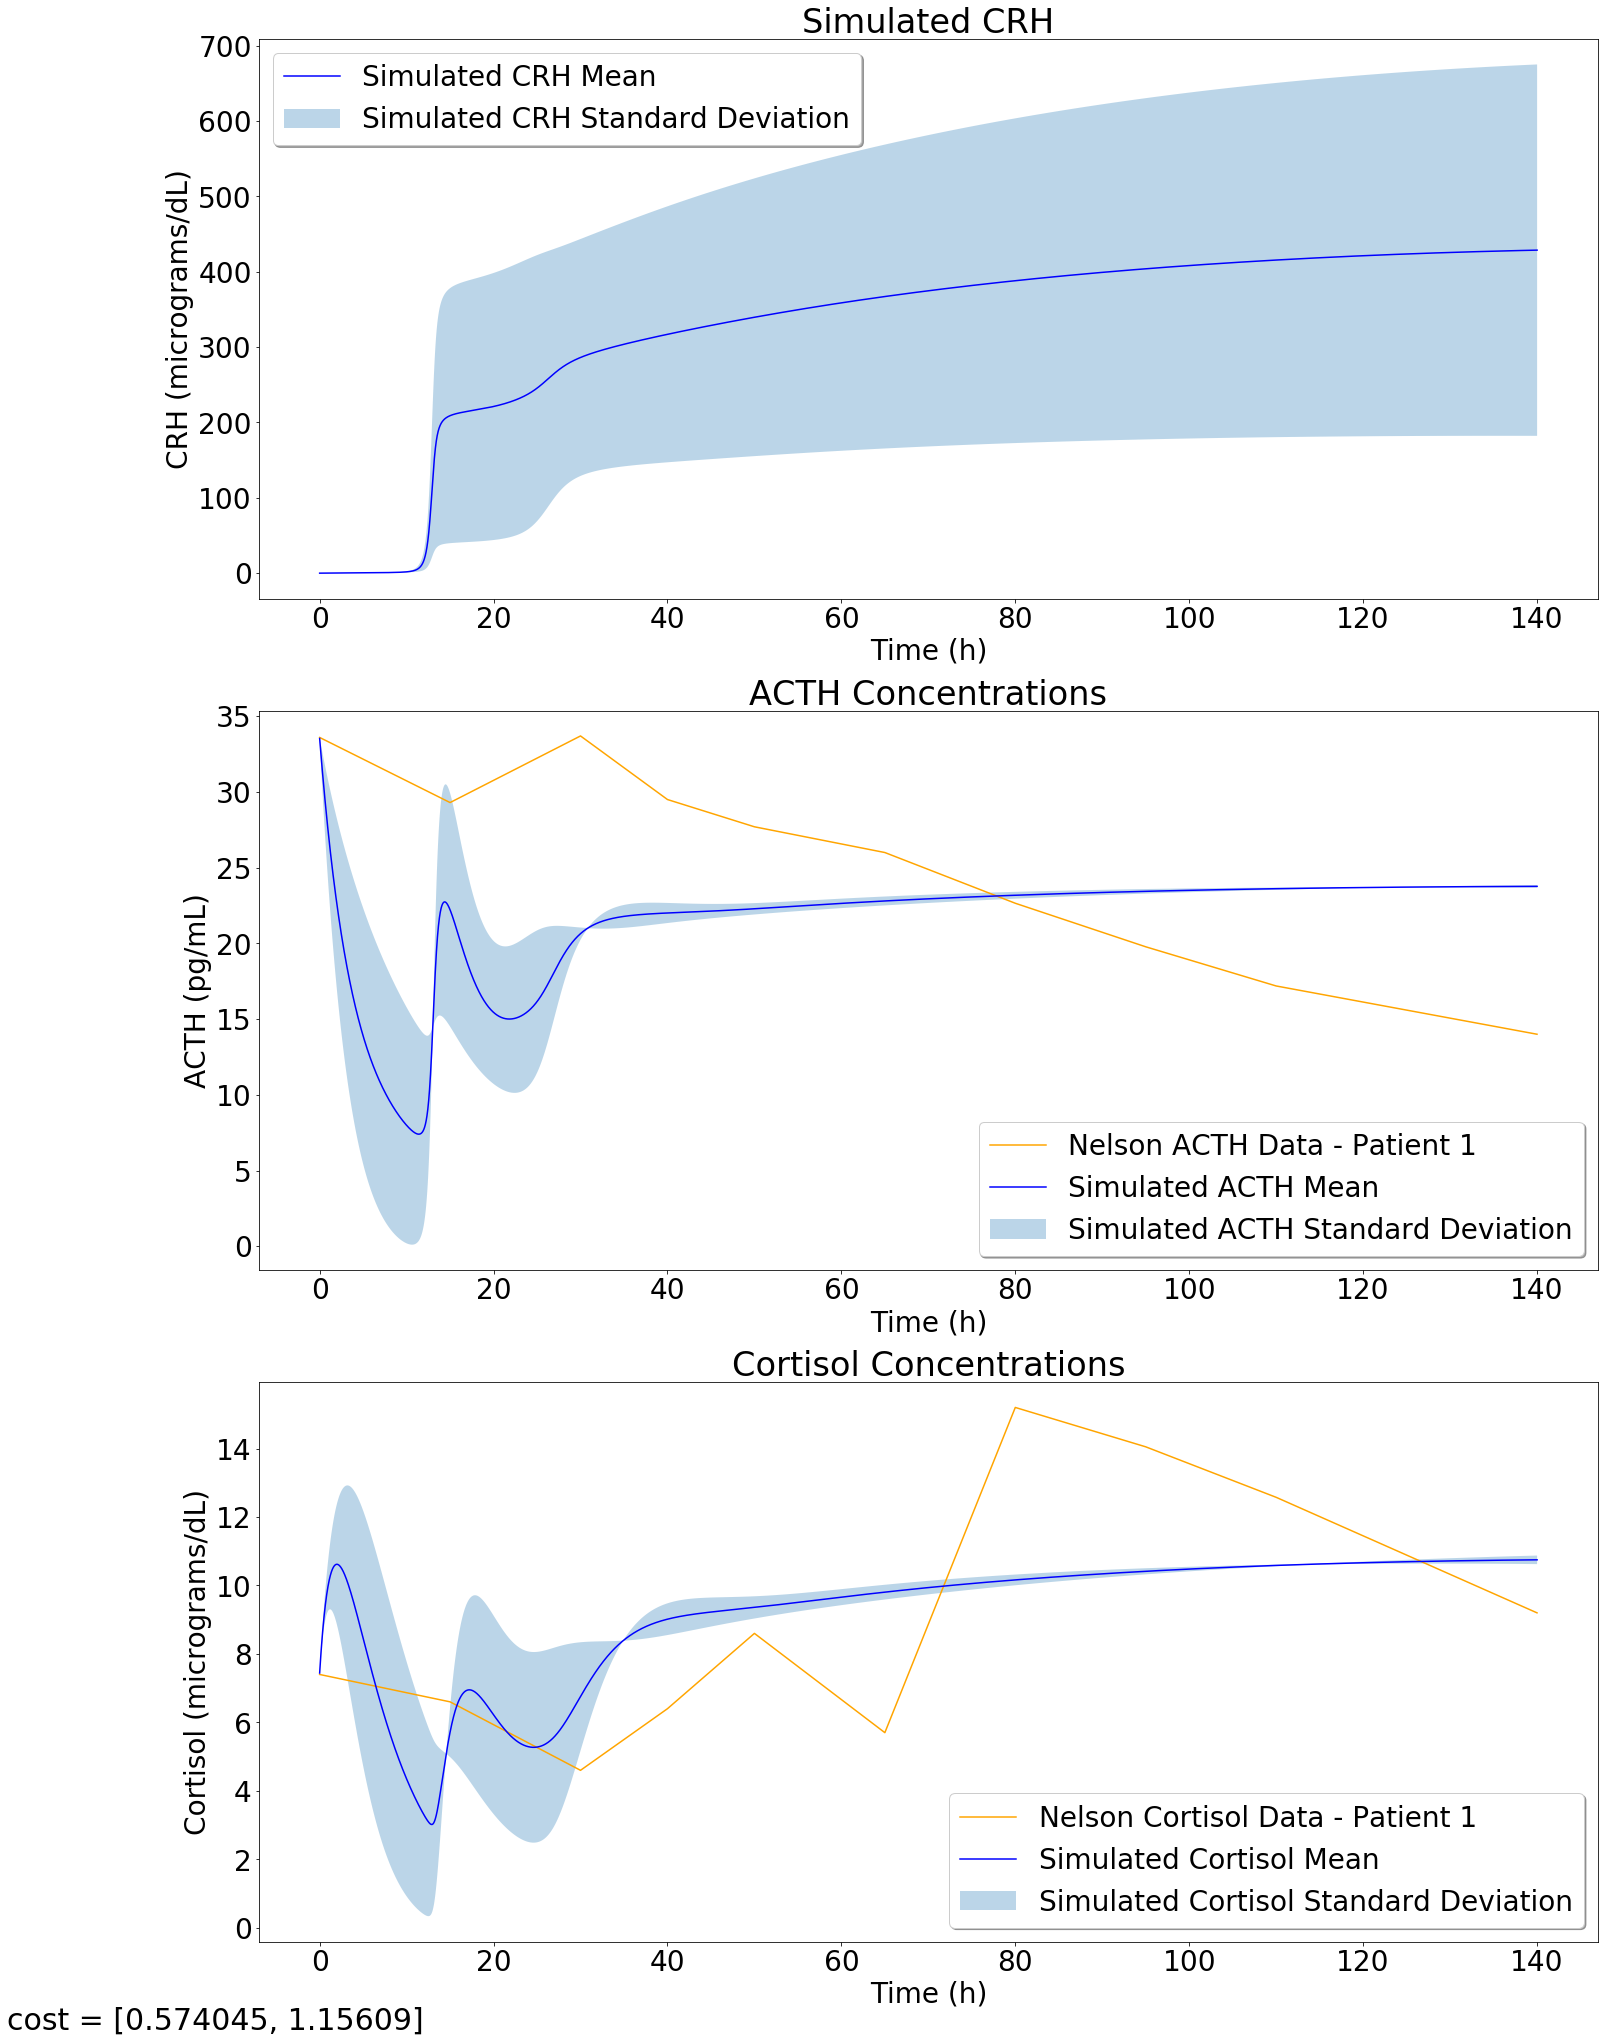

In [61]:
# graphing code for Nelson data

%matplotlib inline
matplotlib.rc('font', **{'size'   : 28})

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (24, 35))

ax1.plot(optimizedSimData[:,0], np.mean(sims_crh, axis = 1), label = "Simulated CRH Mean", color = "blue")
ax1.fill_between(optimizedSimData[:,0], np.mean(sims_crh, axis = 1) - np.std(sims_crh, axis = 1), np.mean(sims_crh, axis = 1) + np.std(sims_crh, axis = 1), alpha = 0.3, label = "Simulated CRH Standard Deviation")
ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "CRH (micrograms/dL)", title = "Simulated CRH")

ax2.plot(nelsonACTH[:,0], nelsonACTH[:,2], label = "Nelson ACTH Data - Patient 1", color = "orange")
ax2.plot(optimizedSimData[:,0], np.mean(sims_acth, axis = 1), label = "Simulated ACTH Mean", color = "blue")
ax2.fill_between(optimizedSimData[:,0], np.mean(sims_acth, axis = 1) - np.std(sims_acth, axis = 1), np.mean(sims_acth, axis = 1) + np.std(sims_acth, axis = 1), alpha = 0.3, label = "Simulated ACTH Standard Deviation")
ax2.legend(loc = "lower right", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "ACTH Concentrations")

ax3.plot(nelsonCortisol[:,0], nelsonCortisol[:,2], label = "Nelson Cortisol Data - Patient 1", color = "orange")
ax3.plot(optimizedSimData[:,0], np.mean(sims_cort, axis = 1), label = "Simulated Cortisol Mean", color = "blue")
ax3.fill_between(optimizedSimData[:,0], np.mean(sims_cort, axis = 1) - np.std(sims_cort, axis = 1), np.mean(sims_cort, axis = 1) + np.std(sims_cort, axis = 1), alpha = 0.3, label = "Simulated Cortisol Standard Deviation")
ax3.legend(loc = "lower right", shadow = True, fancybox = True)
ax3.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Cortisol Concentrations")

# include the value of the cost function for this set of graphs at the bottom of the figure
txt = "cost = [0.574045, 1.15609]"
plt.figtext(0.1, 0.09, txt, wrap = True, horizontalalignment = 'center', fontsize = 30)
#plt.savefig("bangsgaardModel-nelson-patient1-5-iterations-expanded-bounds-normalizedCost.png", dpi = 300)


## No Optimization Run <a name="no-opt"></a>

In [143]:
print(patientFacth_smooth[0,1], patientFcortisol_smooth[0,1])

8.725314 1.158798


In [ ]:
y0 = [5,8.725314,1.158798]

In [ ]:
data_no_opt = model(authors_params, y0)

### Plot the No-Optimization Simulation Against Raw Data <a name="no-optplot"></a>

In [ ]:
%matplotlib inline

#mpld3.enable_notebook()

# I want to graph the following:
#     - Average Cortisol, ACTH and CRH values over 24h period between all parameter sets for each data set
#     - Shaded area for mean +- standard deviation for each parameter for each data set
#     - Plot the raw data values on each plot for comparison

fig1, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize=(15,15))
ax1.plot(data_no_opt[:,0], data_no_opt[:,1], label = "CRH")
ax1.set(xlabel = "Time (min)", ylabel = "CRH (pg/mL)")
ax1.legend(loc="upper right", shadow = True, fancybox = True)
ax2.plot(data_no_opt[:,0], data_no_opt[:,2], label = "ACTH")
ax2.plot(patientFacth[:,0], patientFacth_smooth[:,1], 'm', label = "ACTH Raw Data (Carroll, 2007)")
ax2.set(xlabel = "Time (min)", ylabel = "ACTH (pg/mL)")
ax2.legend(loc="upper right", shadow = True, fancybox = True)
ax3.plot(data_no_opt[:,0], data_no_opt[:,3], label = "Cortisol")
ax3.plot(patientFcortisol[:,0], patientFcortisol_smooth[:,1], 'm', label = "Cortisol Raw Data (Carroll, 2007)")
ax3.set(xlabel = "Time (min)", ylabel = "Cortisol (micrograms/mL)")
ax3.legend(loc="upper right", shadow = True, fancybox = True)

## No Optimization Run--Iterate Over Multiple CRH Initial Conditions <a name="multipleCRH"></a>

In [226]:
# loop through initial conditions for CRH to see how the graph changes
CRH_vals = np.arange(0, 50, 0.1)
IC_array = np.zeros((len(CRH_vals), 3))

for index, item in enumerate(CRH_vals):
    IC_array[index, 0] = item
    IC_array[index, 1] = 8.725314
    IC_array[index, 2] = 1.158798

In [208]:
no_opt = np.zeros((len(CRH_vals), 144003, 4))

In [ ]:
for index, item in enumerate(IC_array):
    print("Run #", index)
    no_opt[index, :, :] = model(authors_params, item)

In [ ]:
CRH_labels = []
ACTH_labels = []
Cortisol_labels = []

for index, item in enumerate(IC_array):
    CRH_labels.append("CRH Simulation #" + str(index) + ": CRH = " + str(item[0]))
    ACTH_labels.append("ACTH Simulation #" + str(index) + ": ACTH = " + str(item[1]))                  
    Cortisol_labels.append("Cortisol Simulation #" + str(index) + ": Cortisol = " + str(item[2]))

In [ ]:
%matplotlib inline

# plot the simulations together to see how increasing initial CRH value
# changes behavior

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15, 15))

for index, item in enumerate(no_opt):
    ax1.plot(item[:,0], item[:,1], label = CRH_labels[index])
    ax2.plot(item[:,0], item[:,2], label = ACTH_labels[index])
    ax3.plot(item[:,0], item[:,3], label = Cortisol_labels[index])

ax1.set(xlabel = "Time (min)", ylabel = "CRH (pg/mL)")
ax1.legend(loc="upper right", shadow = True, fancybox = True)

ax2.plot(patientFacth[:,0], patientFacth_smooth[:,1], 'm', label = "Patient F ACTH - Smoothed")
ax2.set(xlabel = "Time (min)", ylabel = "ACTH (pg/mL)")
ax2.legend(loc="upper right", shadow = True, fancybox = True)

ax3.plot(patientFcortisol[:,0], patientFcortisol_smooth[:,1], 'm', label = "Patient F Cortisol - Smoothed")
ax3.set(xlabel = "Time (min)", ylabel = "Cortisol (micrograms/mL)")
ax3.legend(loc="upper right", shadow = True, fancybox = True)

## Dependencies <a name="dependencies"></a>

In [1]:
%load_ext watermark

In [ ]:
%watermark --iversions